In [1]:
import os, sys

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns
import IPython
%matplotlib widget
%matplotlib notebook

In [3]:
data_dir_full_amp = "../../data/2022-11-28/frq_test_batch_1/"
data_dir_half_amp = "../../data/2022-11-28/frq_test_batch_2/"

In [4]:
dirnames = os.listdir(data_dir_full_amp)
dirnames = list(os.path.join(data_dir_full_amp, f) for f in dirnames)

fnames_full_amp = []

for dirname in dirnames:
    if os.path.isdir(dirname):
        files = os.listdir(dirname)
        for file in files:
            if ".dat" in file:
                fnames_full_amp.append(f"{dirname}/{file}")
                
dirnames = os.listdir(data_dir_half_amp)
dirnames = list(os.path.join(data_dir_half_amp, f) for f in dirnames)

fnames_half_amp = []

for dirname in dirnames:
    if os.path.isdir(dirname):
        files = os.listdir(dirname)
        for file in files:
            if ".dat" in file:
                fnames_half_amp.append(f"{dirname}/{file}")


In [5]:
data_half = dict()
data_full = dict()
init_length = 300
def cache_data(fnames):
    data = dict()
    for fname in fnames:
        dat = pd.read_csv(fname)
        dat["t"] = dat["T_(ms)"]/1000 #ms to s
        dat["y"] = (dat["V_dist_(mA)"]*(-100.0/16.0)+125-11.2625) #convert milliamp to millimeters
        dat["strain"] = (init_length-dat["y"])/init_length
        dat["p_c"] = (dat["Comp_P_(mA)"]-4)*0.75
        dat["v"] = dat["Sys_Volts_(V)"]
        dat["l"] = dat["LC_(grams)"]
        dat["p_p"] = (dat["Piezo_P_(mA)"]-4)*0.75
        dat["p_o"] = 6*(dat["Piezo_out_(mV)"]-4000)/16000 #converting milliamp output to expected bar output
        name = fname.split('/')[-1].split('.')[0].split('-')[-1].split('_')[0].replace(',','.')
        data.update({name:dat})
    return data

data_half = cache_data(fnames_half_amp)
data_full = cache_data(fnames_full_amp)

In [6]:
def plot_test(df, name="Experiment"):
    fig, axes = plt.subplots(5,1, sharex=True, figsize=(15,10))
    axes[0].plot(df["t"], df["y"],linestyle='None',marker='o',markersize=1)
    axes[0].plot(0, 0,linestyle='None',marker='o',markersize=1, color='r')
    axes[0].grid()
    axes[0].set_ylabel("Distance (mm)")

    axes[1].plot(df["t"], df["l"],linestyle='None',marker='o',markersize=1,color='r')
    axes[1].grid()
    axes[1].set_ylabel("Load (grams)")
    
    axes[2].plot(df["t"], df["p_o"],linestyle='None',marker='o',markersize=1)
    axes[2].grid()
    axes[2].plot(df["t"], df["p_p"],linestyle='None',marker='o',markersize=1)
    axes[2].set_ylabel("Pressure - Actuator \n(Bar)")
    #axes[2].set_ylim([-0.25, 6.25])

    axes[2].legend(["Pressure Out","Pressure Gauge"])

    axes[3].plot(df["t"], df["p_c"],linestyle='None',marker='o',markersize=1)
    axes[3].grid()
    #axes[2].set_ylim([-0.25, 6.25])
    axes[3].set_ylabel("Pressure - Comp. \n(Bar)")

    axes[4].plot(df["t"], df["v"],linestyle='None',marker='o',markersize=1)
    axes[4].grid()
    axes[4].set_ylabel("System (V)")
    plt.suptitle(name)
    plt.show()

In [144]:
for key, data in data_half.items():
    name = "Half amp - exp "+key+" rad/s"
    dat = data
    #plot_test(dat, name)
for key, data in data_full.items():
    name = "Half amp - exp "+key+" rad/s"
    dat = data
    #plot_test(dat, name)

Text(0.5, 0.98, 'Half Amplitude Hysteresis (3 Bar +- 0.5 Bar)')

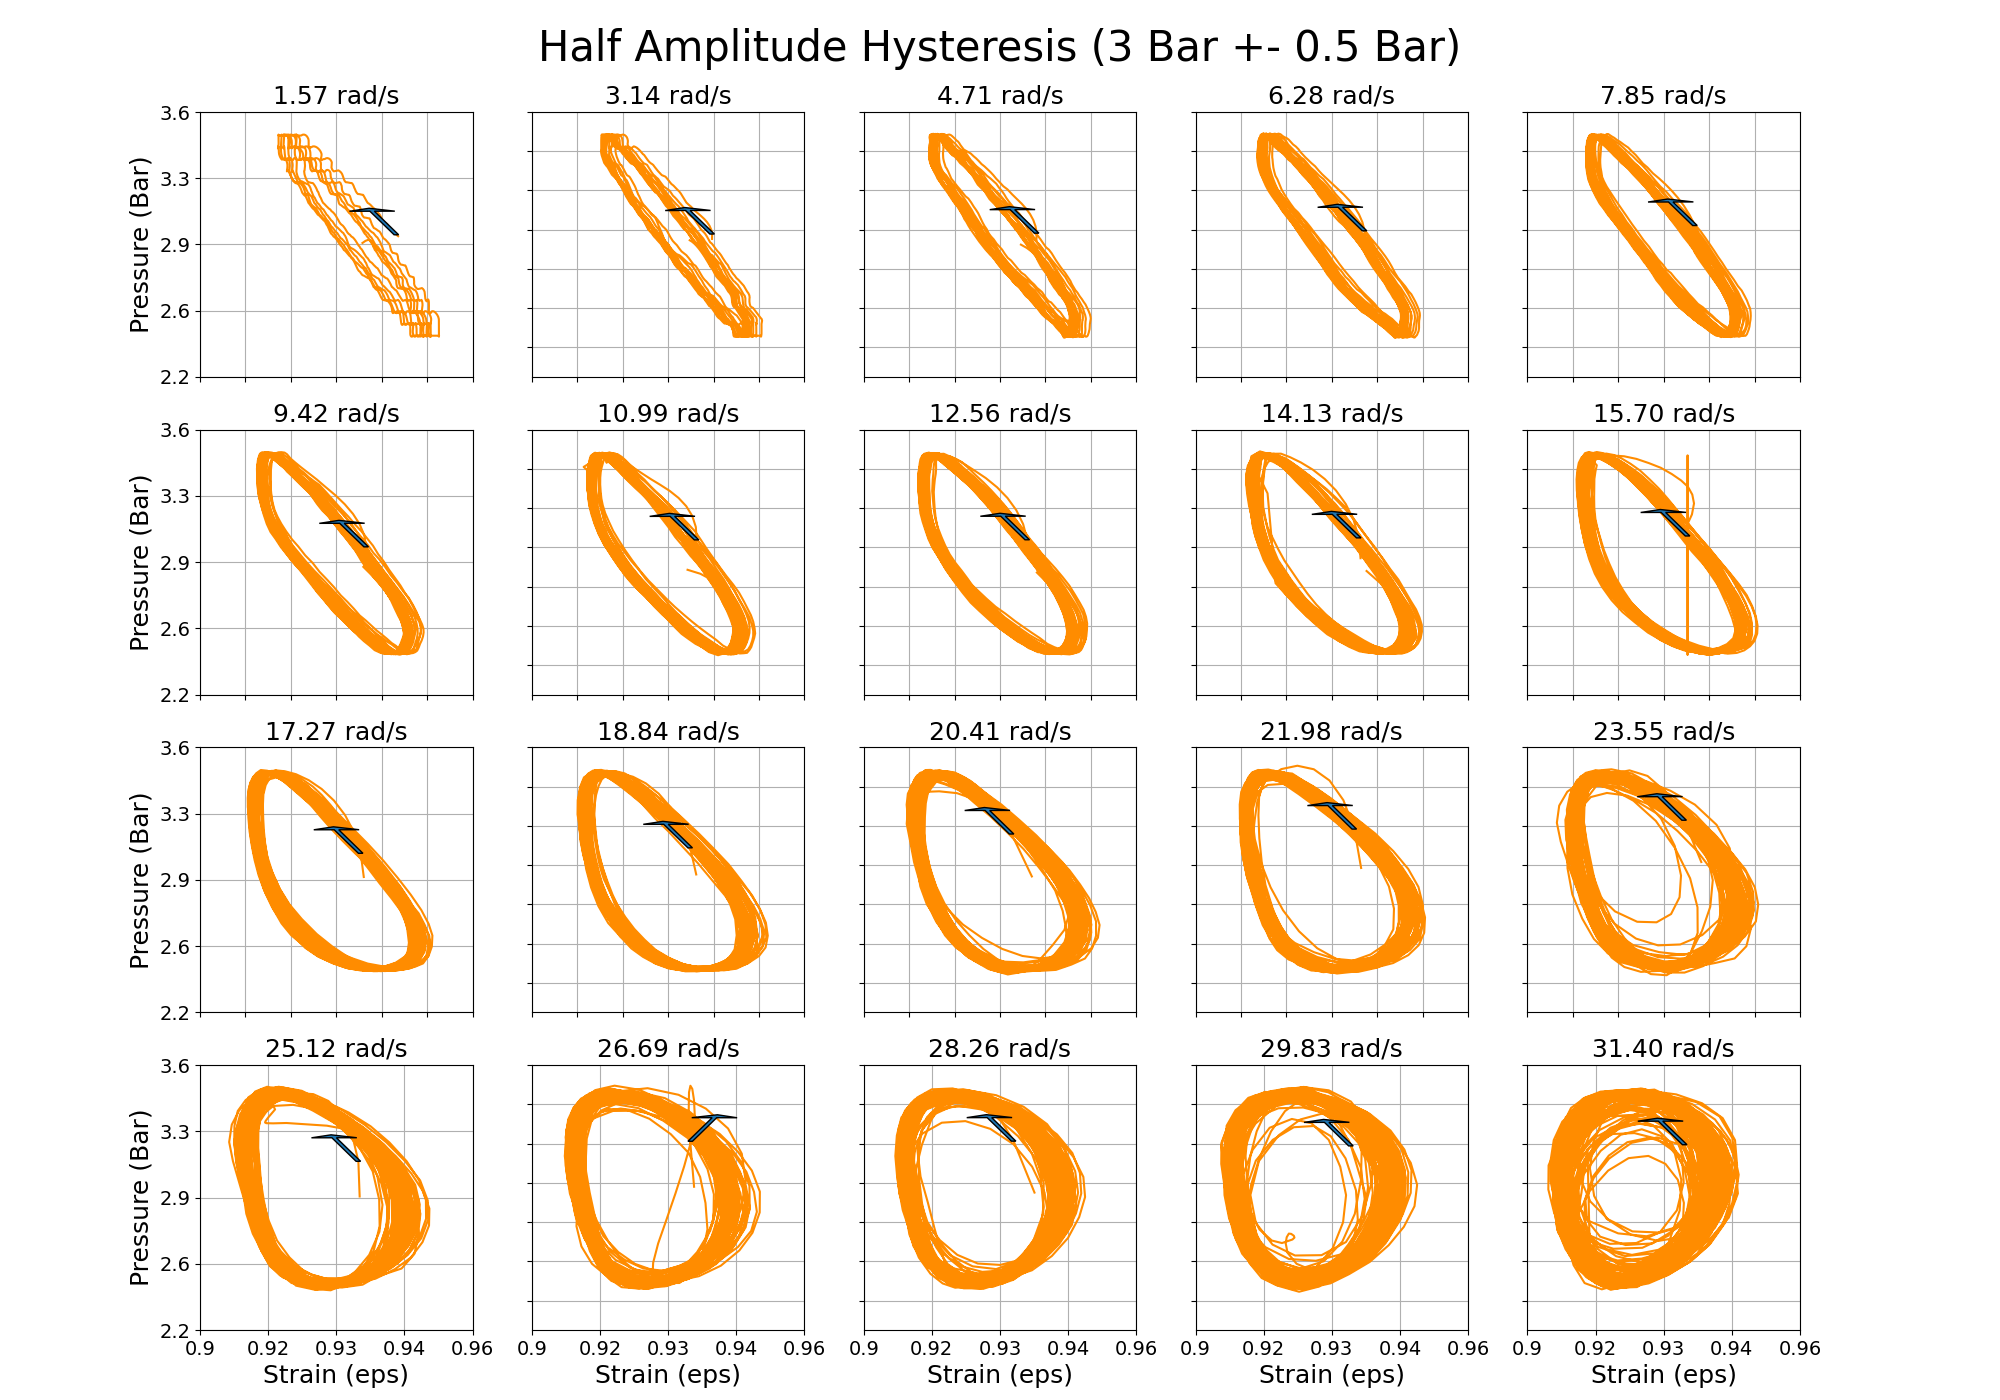

In [172]:
from scipy.signal import savgol_filter

fig, axes = plt.subplots(nrows=4, ncols=len(data_half.keys())//4, figsize=(20,14))
fig.tight_layout(pad=2)
row = 0
col = 0
n_points = len(data_half.keys())
n_points_per_row = n_points//4
accessors = list(data_half.keys())
ordered_accessors = [float(elem) for elem in data_half.keys()]
accessors = [x for _, x in sorted(zip(ordered_accessors, accessors))]
idx = 0
for key in accessors:
    
    frq = key
    dat = data_half[key].copy()
    name = frq+" rad/s"
    bl_idx = ((dat["p_o"] > 0))
    dat = dat[bl_idx]
    dat["p_o"] = savgol_filter(dat["p_o"], 15, 3)
    bl_idx = ((dat["strain"] > 0.7))
    dat = dat[bl_idx]
    dat["strain"] = savgol_filter(dat["strain"], 15, 3)
    h = axes[row][col]
    a_0x = dat['strain'][1]
    a_0y = dat['p_o'][1]
    a_dx = dat['strain'][1:6].diff().mean()
    a_dy = dat['p_o'][1:6].diff().mean()
    sa_dx = a_dx/abs(a_dx)
    sa_dy = a_dy/abs(a_dy)
    mag=0.1
    x_min = 0.9
    x_max = 0.96
    y_min = 2.25
    y_max = 3.6
    x_span = x_max-x_min
    y_span = y_max-y_min
    h.arrow(a_0x, a_0y, x_span*mag*sa_dx, y_span*mag*sa_dy, shape='full', lw=1, length_includes_head=True, head_width=.01, zorder=10)
    
    h.plot(dat['strain'], dat['p_o'], color="darkorange")
    
    h.set_title(name, fontsize=18)
    h.set_xlim((x_min, x_max))
    h.set_ylim((y_min, y_max))
    h.axes.yaxis.set_ticklabels([])
    h.axes.xaxis.set_ticklabels([])
    if row==0:
        fig.subplots_adjust(top=1)
    if col == 0:
        h.set_ylabel("Pressure (Bar)", fontsize=18)
        y_ticks = np.linspace(y_min,y_max,5)
        h.set_yticks(y_ticks)
        h.axes.yaxis.set_ticklabels([round(elem, 1) for elem in y_ticks])
        h.tick_params(axis='y', which='major', labelsize=14)
    if row == 3:
        h.set_xlabel("Strain (eps)", fontsize=18)
        x_ticks = np.linspace(x_min,x_max,5)
        h.set_xticks(x_ticks, fontsize=18)
        h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks])
        h.tick_params(axis='x', which='major', labelsize=14)
    h.grid()
    col+=1
    if(col == n_points_per_row):
        col = 0
        row+=1
plt.subplots_adjust(top=0.92, left=0.1, right=0.9, bottom=0.05)
fig.suptitle("Half Amplitude Hysteresis (3 Bar +- 0.5 Bar)", fontsize=30, x=0.5, y=0.98)

Text(0.5, 0.98, 'Full Amplitude Hysteresis (3 Bar +- 3 Bar)')

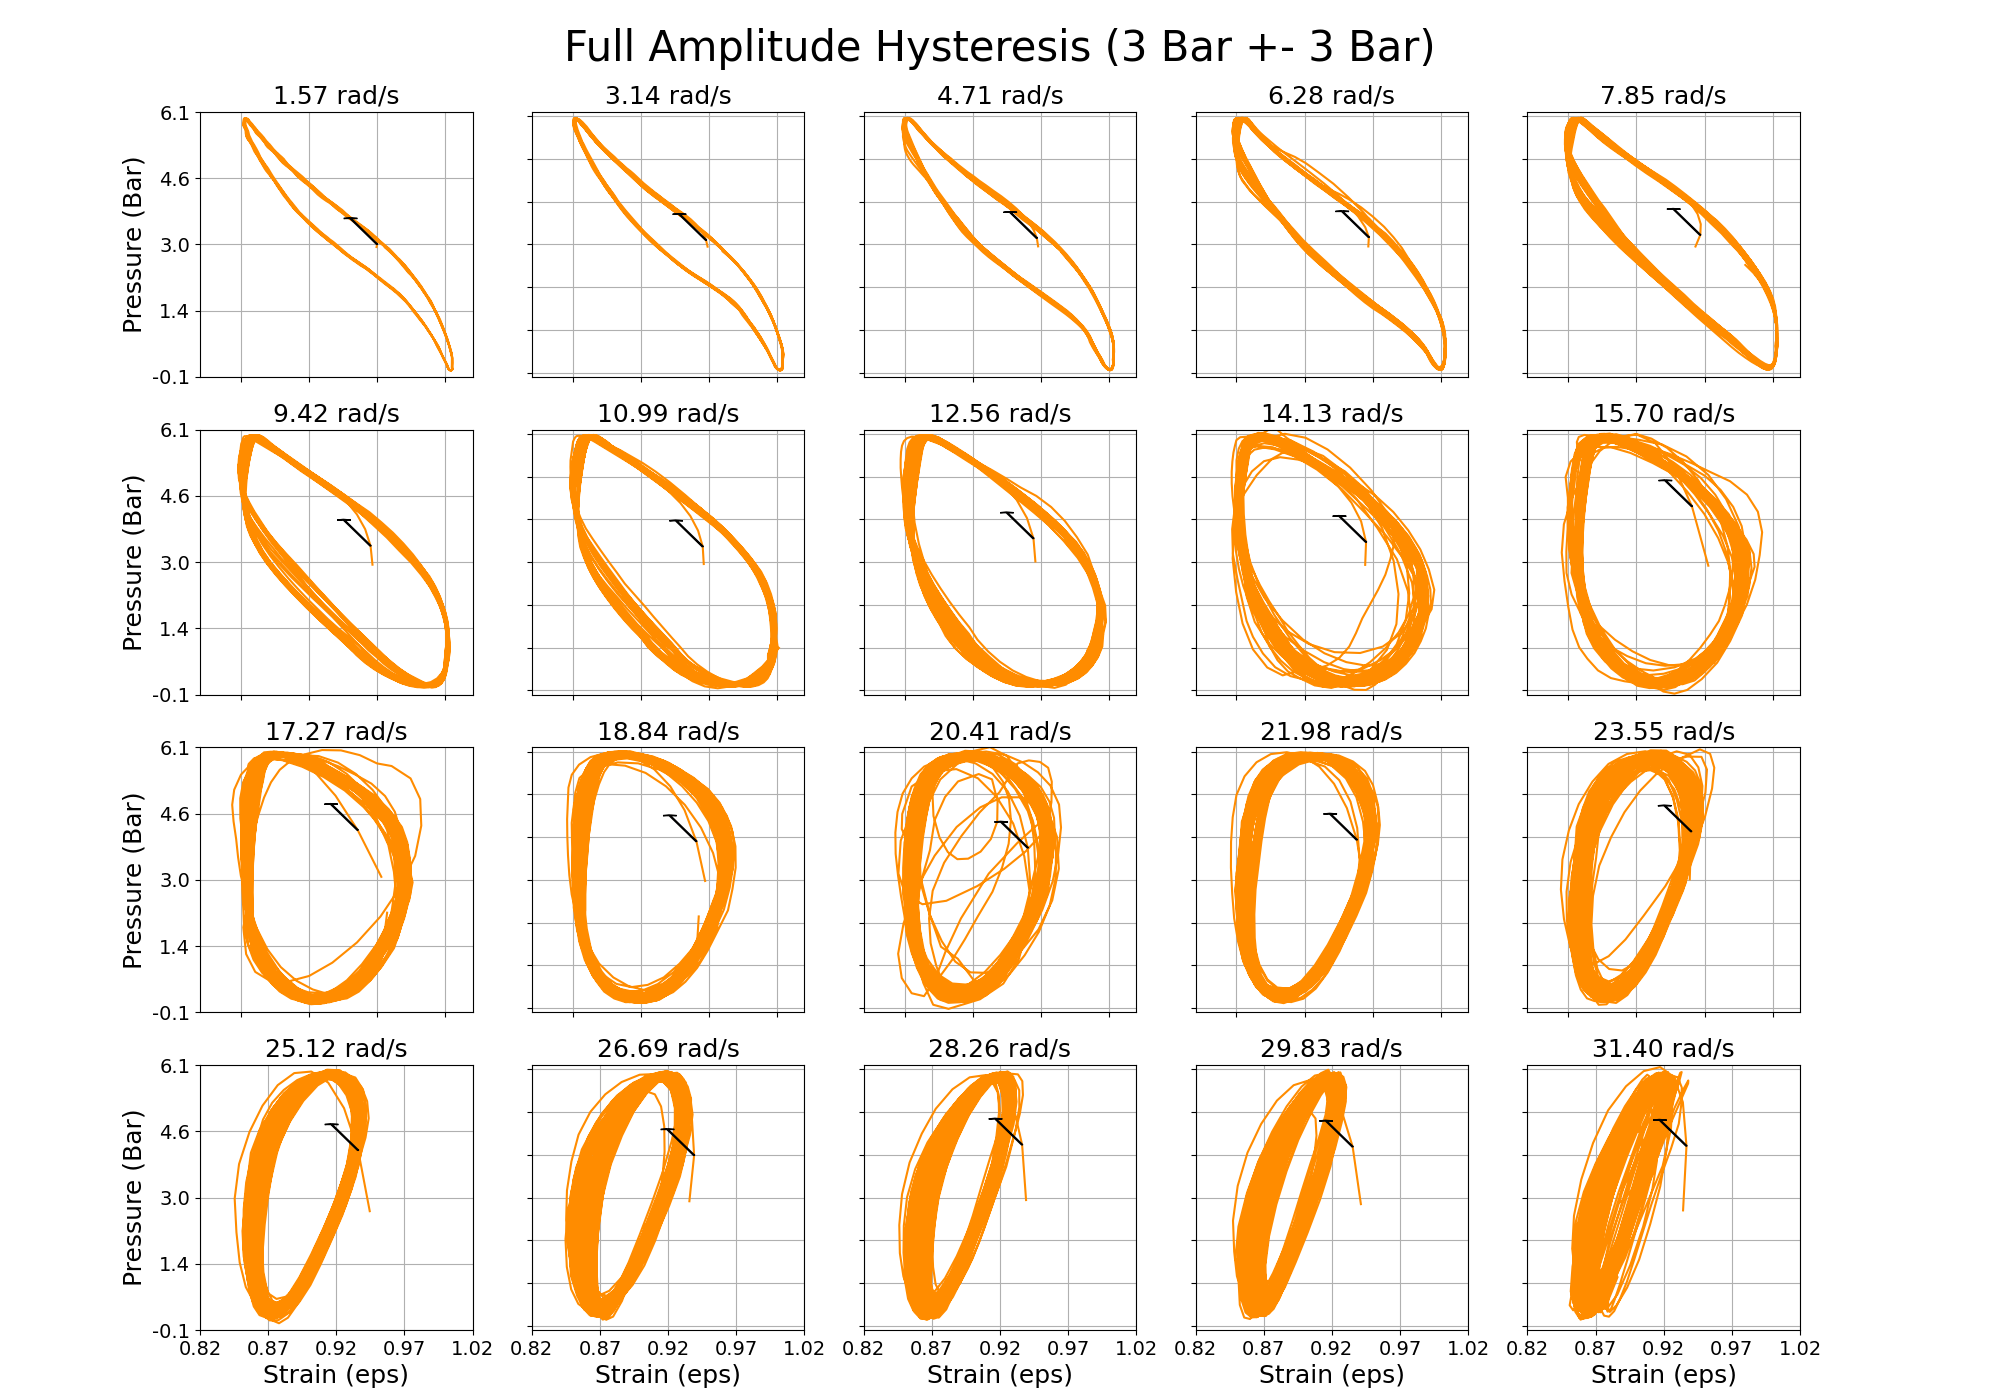

In [173]:
fig, axes = plt.subplots(nrows=4, ncols=len(data_full.keys())//4, figsize=(20,14))
fig.tight_layout(pad=2)
row = 0
col = 0
n_points = len(data_full.keys())
n_points_per_row = n_points//4
accessors = list(data_full.keys())
ordered_accessors = [float(elem) for elem in data_full.keys()]
accessors = [x for _, x in sorted(zip(ordered_accessors, accessors))]
idx = 0
for key in accessors:
    
    frq = key
    dat = data_full[key].copy()
    name = frq+" rad/s"
    bl_idx = ((dat["p_o"] > 0))
    dat = dat[bl_idx]
    dat["p_o"] = savgol_filter(dat["p_o"], 15, 3)
    bl_idx = ((dat["strain"] > 0.7))
    dat = dat[bl_idx]
    dat["strain"] = savgol_filter(dat["strain"], 15, 3)
    h = axes[row][col]
    a_0x = dat['strain'][1]
    a_0y = dat['p_o'][1]
    a_dx = dat['strain'][1:6].diff().mean()
    a_dy = dat['p_o'][1:6].diff().mean()
    sa_dx = a_dx/abs(a_dx)
    sa_dy = a_dy/abs(a_dy)
    mag=0.1
    x_min = 0.82
    x_max = 1.02
    y_min = -0.1
    y_max = 6.1
    x_span = x_max-x_min
    y_span = y_max-y_min
    h.arrow(a_0x, a_0y, x_span*mag*sa_dx, y_span*mag*sa_dy, shape='full', lw=1, length_includes_head=True, head_width=.01, zorder=10)
    
    h.plot(dat['strain'], dat['p_o'], color="darkorange")
    
    h.set_title(name, fontsize=18)
    h.set_xlim((x_min, x_max))
    h.set_ylim((y_min, y_max))
    h.axes.yaxis.set_ticklabels([])
    h.axes.xaxis.set_ticklabels([])
    if row==0:
        fig.subplots_adjust(top=1)
    if col == 0:
        h.set_ylabel("Pressure (Bar)", fontsize=18)
        y_ticks = np.linspace(y_min,y_max,5)
        h.set_yticks(y_ticks)
        h.axes.yaxis.set_ticklabels([round(elem, 1) for elem in y_ticks])
        h.tick_params(axis='y', which='major', labelsize=14)
    if row == 3:
        h.set_xlabel("Strain (eps)", fontsize=18)
        x_ticks = np.linspace(x_min,x_max,5)
        h.set_xticks(x_ticks, fontsize=18)
        h.axes.xaxis.set_ticklabels([round(elem, 2) for elem in x_ticks])
        h.tick_params(axis='x', which='major', labelsize=14)
    h.grid()
    col+=1
    if(col == n_points_per_row):
        col = 0
        row+=1
plt.subplots_adjust(top=0.92, left=0.1, right=0.9, bottom=0.05)
fig.suptitle("Full Amplitude Hysteresis (3 Bar +- 3 Bar)", fontsize=30, x=0.5, y=0.98)